# Gram-schmidt and the KF

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [3]:
%config InlineBackend.figure_format = "retina"

## The best linear unbiased predictor for a signal plus noise model

$$
    {\bf A}_\text{opt} = \arg\min_{\bf A}\| f_t - {\bf A}\,y_{1:t} \|_2^2
$$

In [4]:
def ssm(key, signal_init, n_steps, qt, rt):
    def ssm_step(signal_prev, key):
        key_measurement, key_state = jax.random.split(key)
        ut = jax.random.normal(key_state) * qt
        et = jax.random.normal(key_measurement) * rt

        signal = signal_prev + ut
        measurement = signal + et

        return signal, (signal, measurement)

    keys = jax.random.split(key, n_steps)
    _, (signals, measurements) = jax.lax.scan(ssm_step, signal_init, keys)
    return signals, measurements

In [5]:
key = jax.random.PRNGKey(314)
key_sample, key_test = jax.random.split(key)

In [6]:
signal_init = 0.0
n_steps = 100
qt = 0.05
rt = 0.1
signals, measurements = ssm(key, signal_init, n_steps, qt, rt)

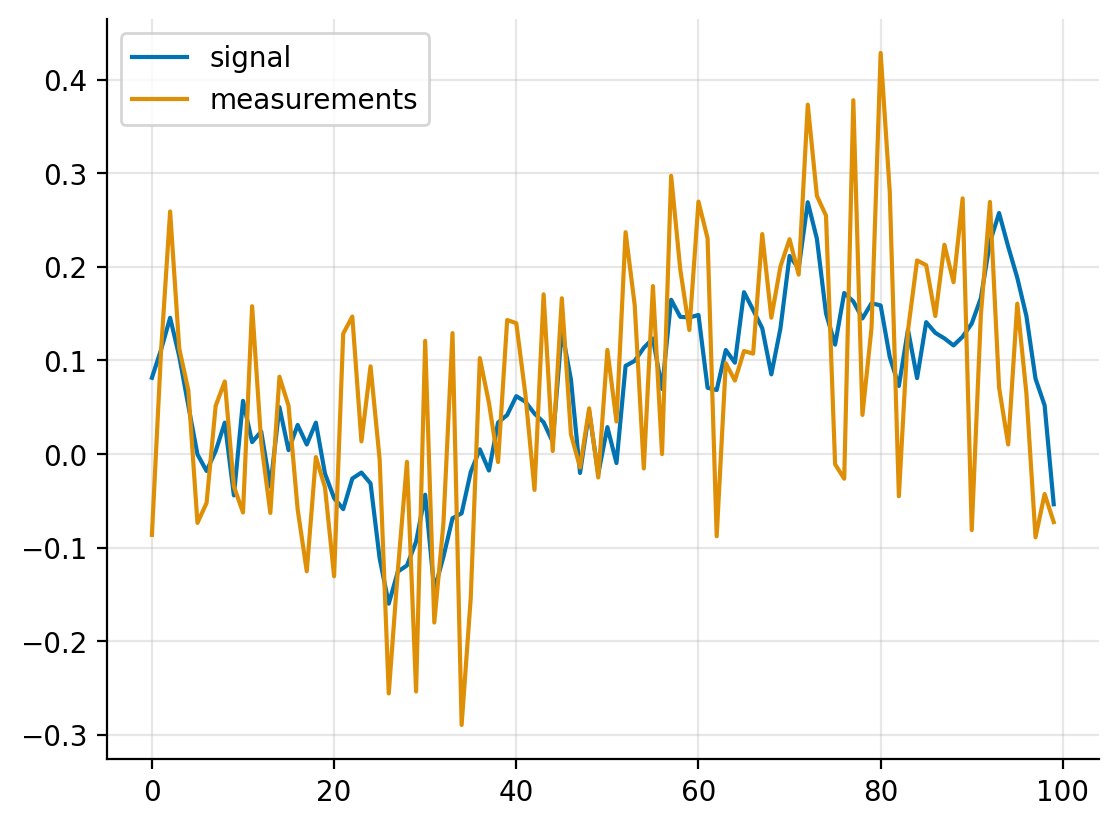

In [7]:
plt.plot(signals, label="signal")
plt.plot(measurements, label="measurements")
plt.legend()
plt.grid(alpha=0.3)

In [8]:
vssm = jax.vmap(ssm, in_axes=(0, None, None, None, None), out_axes=-1)

In [9]:
n_trials = 500
keys = jax.random.split(key_sample, n_trials)

In [10]:
n_steps = 100
signal_init = 0.0
rt = 0.1
qt = 0.05

signals, measurements = vssm(keys, signal_init, n_steps, qt, rt)

In [11]:
signals.shape

(100, 500)

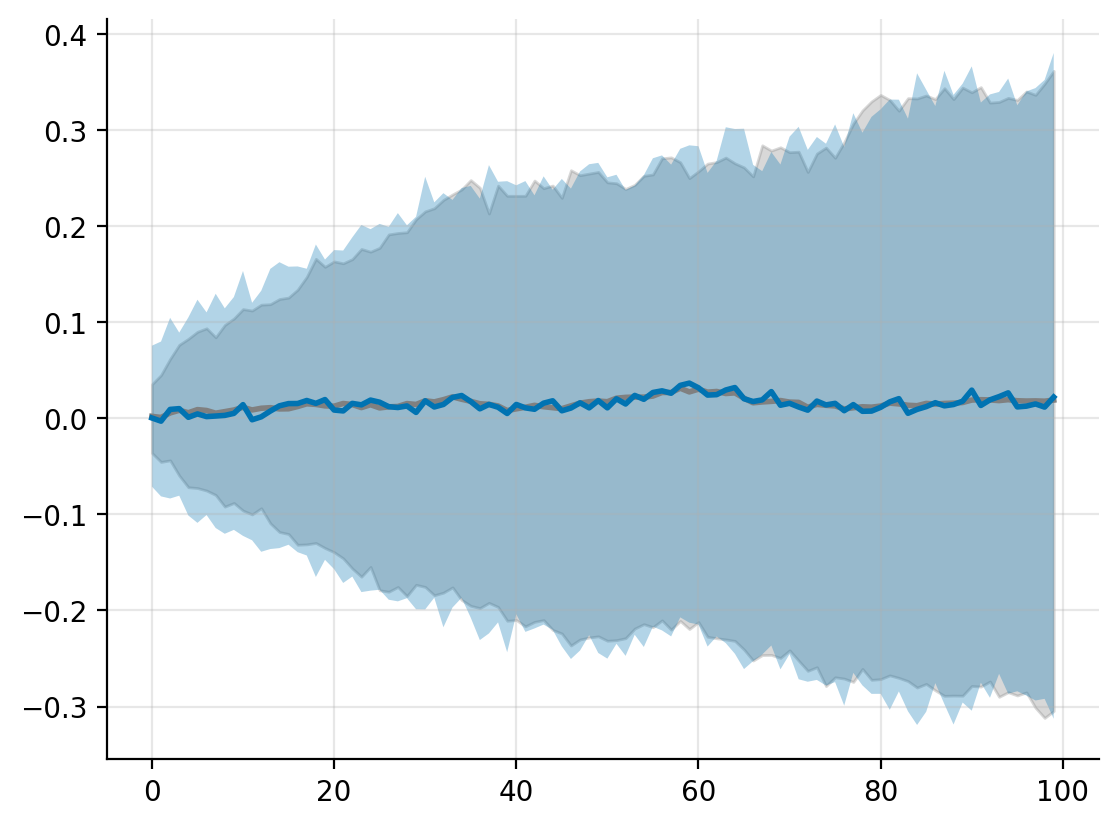

In [40]:
xrange = jnp.arange(n_steps)

smid = signals.mean(axis=1)
shigh = jnp.quantile(signals, 0.75, axis=1)
sslow = jnp.quantile(signals, 0.25, axis=1)

plt.fill_between(xrange, shigh, sslow, color="gray", alpha=0.3)
plt.plot(xrange, smid, c="gray", linewidth=2)

# plt.plot(signals.T)
plt.grid(alpha=0.3)

xrange = jnp.arange(n_steps)

smid = measurements.mean(axis=1)
shigh = jnp.quantile(measurements, 0.75, axis=1)
sslow = jnp.quantile(measurements, 0.25, axis=1)

plt.fill_between(xrange, shigh, sslow, alpha=0.3)
plt.plot(xrange, smid, linewidth=2)

# plt.plot(signals.T)
plt.grid(alpha=0.3)

In [41]:
measurements.shape

(100, 500)

In [42]:
signals.shape

(100, 500)

In [43]:
C = jnp.r_[signals[-1, :][None, :], measurements]
C = jnp.cov(C)
C.shape

(101, 101)

In [44]:
var_f = C[0, 0]
cov_fy = C[0, 1:] # Cov(ft, y[1:t])
var_y = C[1:, 1:] # var(yt)

In [45]:
A = jnp.einsum("i,ij->j", cov_fy, jnp.linalg.inv(var_y))
blup = A @ measurements[:, 0]
blup

Array(0.27003008, dtype=float32)

In [18]:
blup = jnp.einsum("i,ij,j->", cov_fy, jnp.linalg.inv(var_y), measurements[:, 0])
blup

Array(0.27003008, dtype=float32)

In [19]:
s = jnp.sqrt(var_f - A @ var_y @ A.T)

ymin, ymax = float(blup - 2 * s), float(blup + 2 * s)

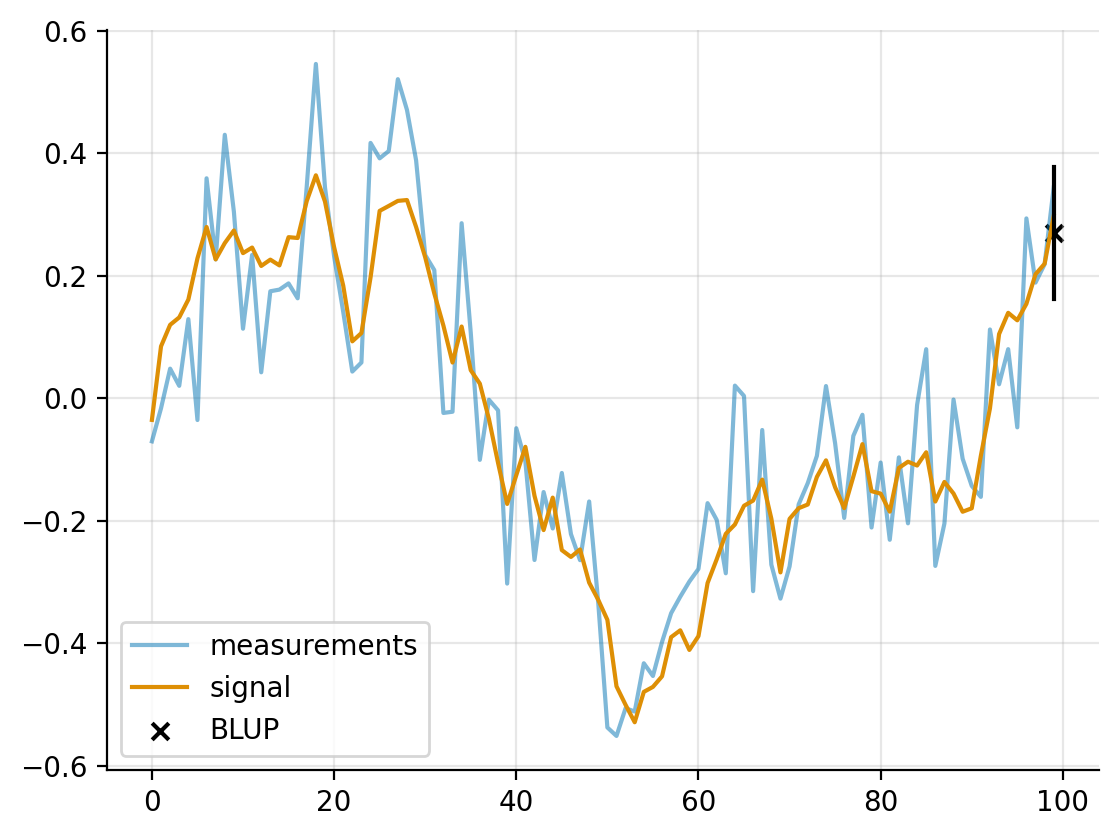

In [20]:
plt.plot(xrange, measurements[:, 0], label="measurements", alpha=0.5)
plt.plot(xrange, signals[:, 0], label="signal")

plt.plot([xrange[-1], xrange[-1]], [ymin, ymax], c="black")
plt.scatter(xrange[-1], blup, label="BLUP", c="black", marker="x")
plt.legend()
plt.grid(alpha=0.3)

# Numerical evaluation of the BLUP

The BLUP estimate over multiple samples can be evaluated in an out-of-sample test-set.
That is
$$
    f_{t|j} = {\rm Cov}(f_t, y_{1:j})\,{\rm Var}(y_{1:j})^{-1}\,y_{1:j}
$$
can be better thought of as
$$
    f_{t|j} = {\rm Cov}(F_t, Y_{1:j})\,{\rm Var}(Y_{1:j})^{-1}\,y_{1:j}
$$
with $F_t$ and $Y_{1:j}$ a sequence of random variables and $y_{1:j}$ the measurements.

In [115]:
n_trials_test = 20
keys_test = jax.random.split(key_test, n_trials_test)

In [116]:
signals_test, measurements_test = vssm(keys_test, signal_init, n_steps, qt, rt)

## Smoothing — $f_{k|t}$
For $k=1,\ldots,t$.

In [110]:
C = jnp.r_[signals, measurements]
C = jnp.cov(C)
C.shape

(200, 200)

In [111]:
cov_fy = C[:n_steps, n_steps:] # Cov(ft, y[1:t])
var_y = C[n_steps:, n_steps:] # var(yt)

In [117]:
blup_test = jnp.einsum("ti,ij,js->ts", cov_fy, jnp.linalg.inv(var_y), measurements_test)

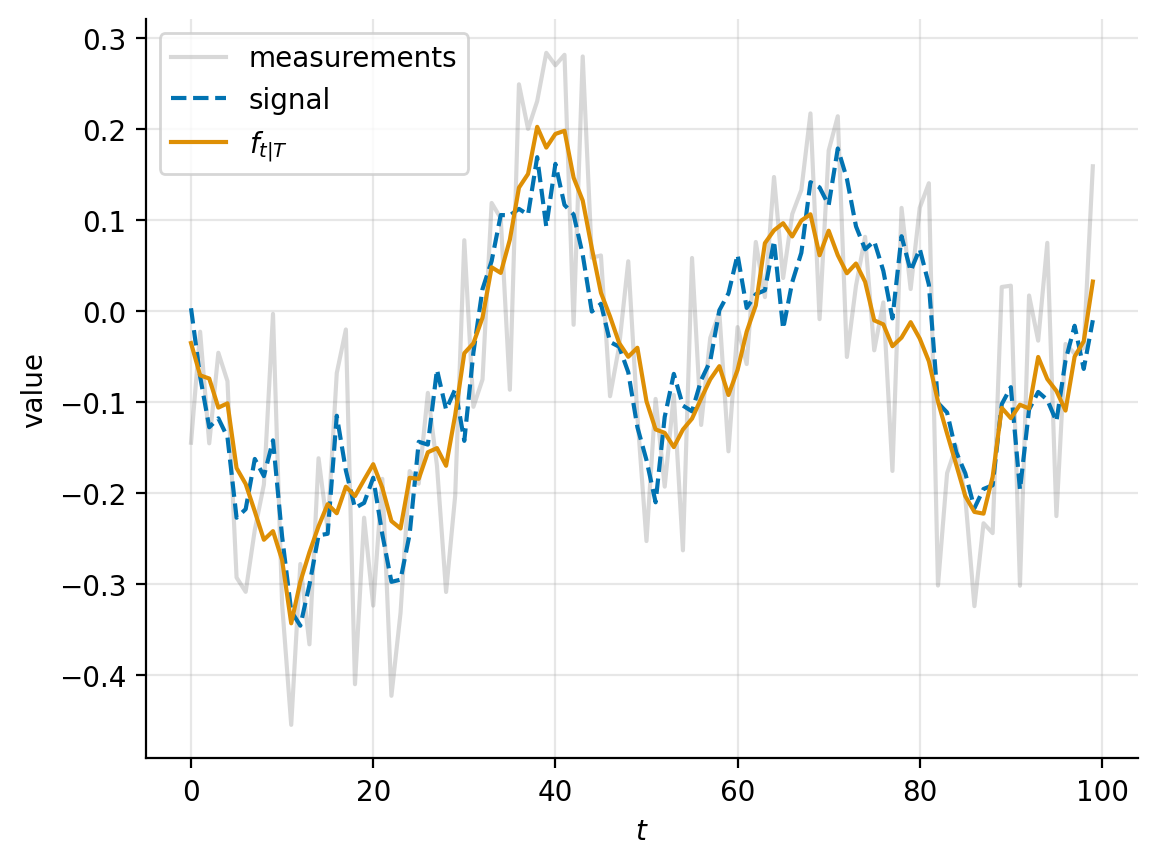

In [118]:
s = 3
plt.plot(xrange, measurements_test[:, s], label="measurements", alpha=0.3, c="gray")
plt.plot(xrange, signals_test[:, s], label="signal", linestyle="--")
plt.plot(blup_test[:, s], label="$f_{t|T}$")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("value")
plt.grid(alpha=0.3)

## Filtering — $f_{t|t}$
For $t=1,\ldots,T$.

$$
    f_{t|t} = {\rm Cov}(F_t, Y_{1:t})\,{\rm Var}(Y_{1:t})^{-1}\,y_{1:t}
$$

In [183]:
C = jnp.r_[signals, measurements]
C = jnp.cov(C)

In [184]:
cov_fy = C[:n_steps, n_steps:] # Cov(ft, y[1:t])
var_y = C[n_steps:, n_steps:] # var(yt)

In [187]:
mask = jnp.tril(jnp.ones((n_steps, n_steps)))

In [188]:
filter_steps = jnp.zeros(n_steps)
for t in range(n_steps):
    val = jnp.einsum("i,ij,j->", cov_fy[t, :t], jnp.linalg.inv(var_y[:t, :t]), measurements_test[:t, s])
    filter_steps = filter_steps.at[t].set(val)

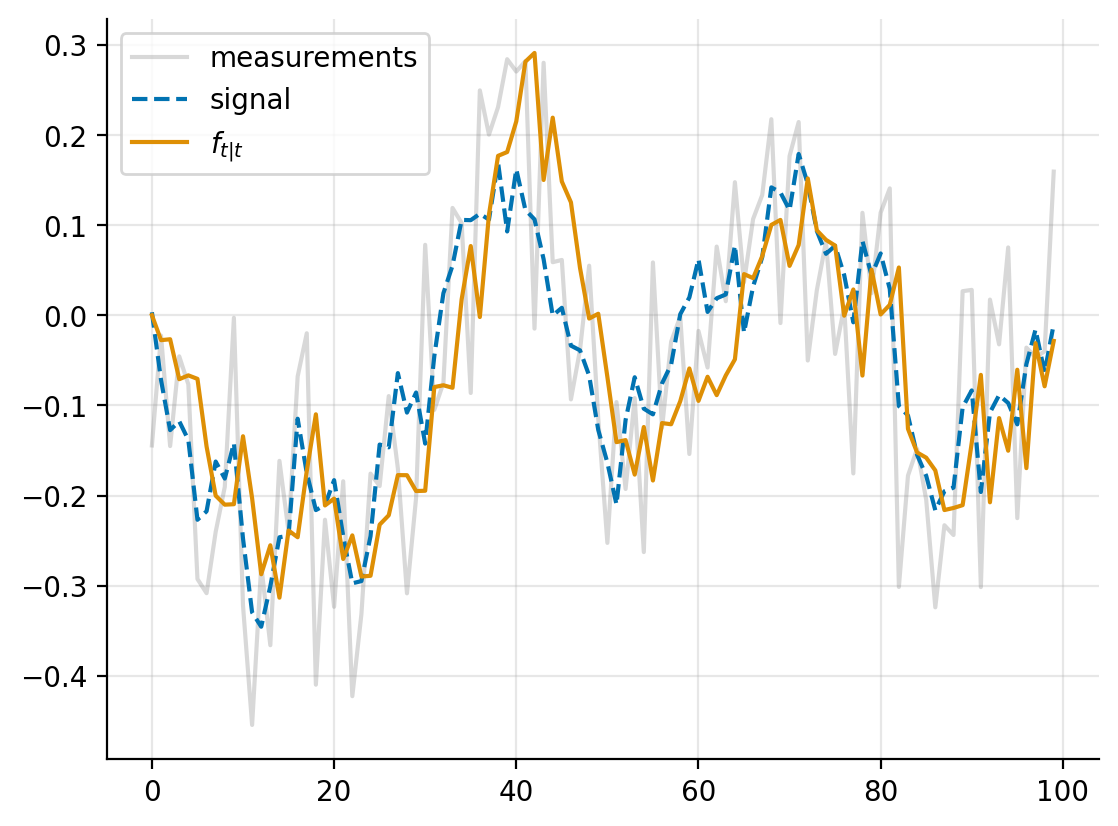

In [189]:
plt.plot(xrange, measurements_test[:, s], label="measurements", alpha=0.3, c="gray")
plt.plot(xrange, signals_test[:, s], label="signal", linestyle="--")
plt.plot(filter_steps, label="$f_{t|t}$")
plt.legend()
plt.grid(alpha=0.3)

## One-step-ahead forecast — $f_{t|t-1}$
For $t=1,\ldots,T$.

$$
    f_{t+1|t} = {\rm Cov}(F_t, Y_{1:t})\,{\rm Var}(Y_{1:t})^{-1}\,y_{1:t}
$$

## Fixed-lag smoothing — $f_{t|t+k}$
For $t=1,\ldots,T$.

$$
    f_{t|t+k} = {\rm Cov}(F_{t}, Y_{1:t+k})\,{\rm Var}(Y_{1:t+k})^{-1}\,y_{1:t+k}
$$

In [201]:
C = jnp.r_[signals, measurements]
C = jnp.cov(C)

In [202]:
cov_fy = C[:n_steps, n_steps:] # Cov(ft, y[1:t])
var_y = C[n_steps:, n_steps:] # var(yt)

In [203]:
mask = jnp.tril(jnp.ones((n_steps, n_steps)))

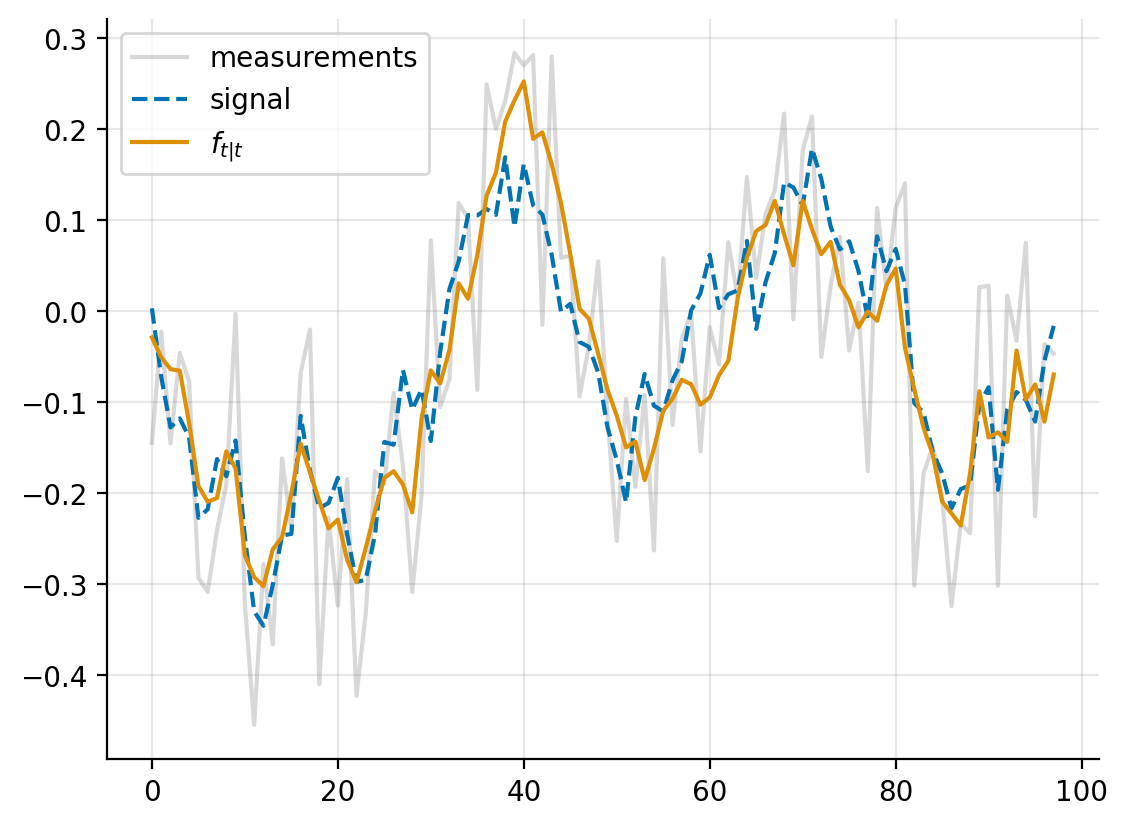

In [239]:
k = 2
filter_steps = jnp.zeros(n_steps - k)
for t in range(n_steps - k):
    val = jnp.einsum("i,ij,j->", cov_fy[t, :t+k], jnp.linalg.inv(var_y[:t+k, :t+k]), measurements_test[:t+k, s])
    filter_steps = filter_steps.at[t].set(val)

xrange = jnp.arange(n_steps - k)

plt.plot(xrange, measurements_test[:-k, s], label="measurements", alpha=0.3, c="gray")
plt.plot(xrange, signals_test[:-k, s], label="signal", linestyle="--")
plt.plot(filter_steps, label="$f_{t|t}$")
plt.legend()
plt.grid(alpha=0.3)

### Multiple values of $k$

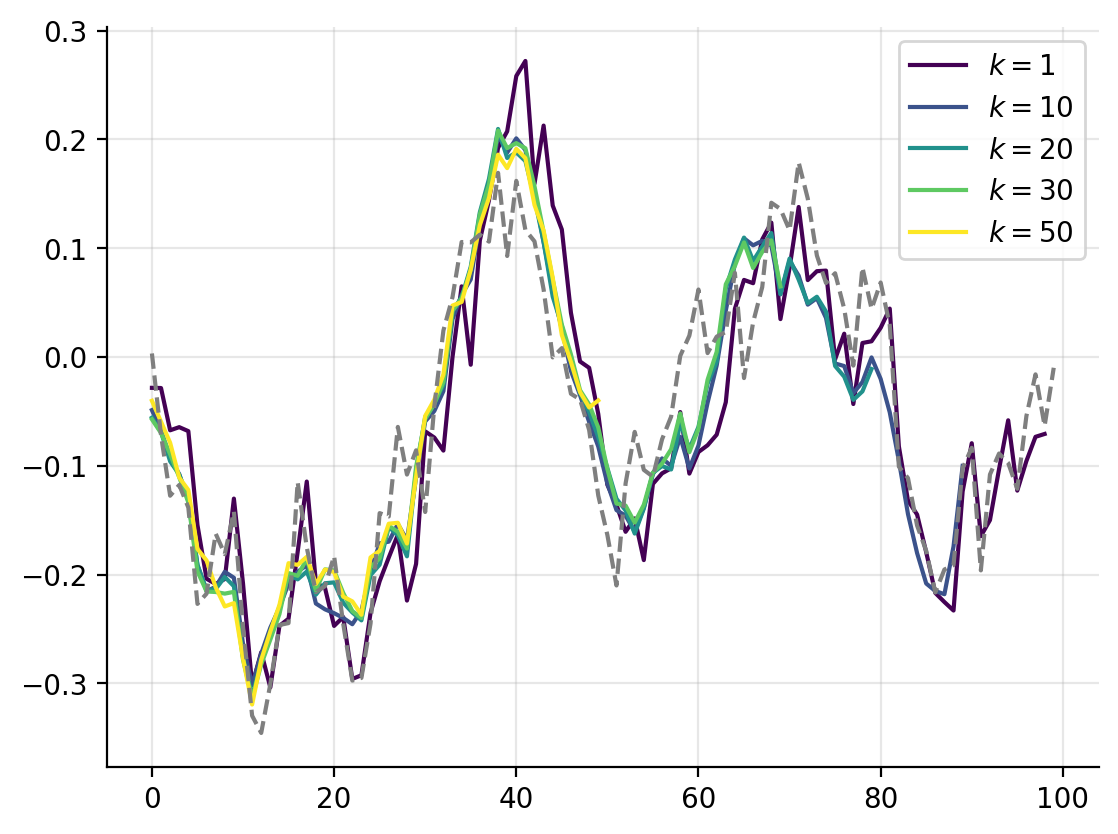

In [251]:
k_values = [1, 10, 20, 30, 50]
colors = plt.cm.viridis(jnp.linspace(0, 1, len(k_values)))
for color, k in zip(colors, k_values):
    filter_steps = jnp.zeros(n_steps - k)
    for t in range(n_steps - k):
        val = jnp.einsum("i,ij,j->", cov_fy[t, :t+k], jnp.linalg.inv(var_y[:t+k, :t+k]), measurements_test[:t+k, s])
        filter_steps = filter_steps.at[t].set(val)
    
    xrange = jnp.arange(n_steps - k)
    
    # plt.plot(xrange, measurements_test[:-k, s], label="measurements", alpha=0.3, c="gray")
    # plt.plot(xrange, signals_test[:-k, s], label="signal", linestyle="--")
    plt.plot(filter_steps, label=f"$k={k}$", color=color)
    
plt.legend()
plt.plot(signals_test[:, s], label="signal", linestyle="--", color="tab:gray")
plt.grid(alpha=0.3)